In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
#Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        #basically makes sure the discriminator is not perfect,
        #so that the generator never has a chance to learn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [4]:
def plot_images(n_images, generator, latent_dim):
    random_latent_vectors = keras.random.normal(
            shape=(n_images, latent_dim), seed = keras.random.SeedGenerator(1322)
        )

    images = (generator(random_latent_vectors) + 1.) / 2.

    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
    plt.show()

In [5]:
dc_latent_dim = 100

dcgenerator = keras.Sequential(
    [
        keras.Input(shape=(dc_latent_dim,)),
        layers.Dense(7*7*128),
        layers.Reshape([7, 7, 128]), #128 feature maps of 7*7
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = "same", activation = "relu"), #strides = 2 -> 14*14 maps - 64 of them
        layers.BatchNormalization(),
        layers.Conv2DTranspose(1, kernel_size = 5, strides = 2, padding = "same", activation = "tanh") #1 image of size 28*28
    ],
    name="dcgenerator",
)

dcdiscriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size = 5, strides = 2, padding = "same", activation = layers.LeakyReLU(0.2)), #strided convolution
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size = 5, strides = 2, padding = "same", activation = layers.LeakyReLU(0.2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="dcdiscriminator",
)

epochs = 50

dcgan = GAN(discriminator=dcdiscriminator, generator=dcgenerator, latent_dim=dc_latent_dim)
dcgan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

X_train_dcgan = (X_train.reshape(-1, 28, 28, 1) * 2. - 1.) #btwn -1 and 1 - to match tanh output

dcgan.fit(X_train_dcgan, epochs=epochs)

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - d_loss: 0.6751 - g_loss: 0.8149
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.6328 - g_loss: 0.9333
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5811 - g_loss: 1.0901
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5469 - g_loss: 1.1940
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5160 - g_loss: 1.2482
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.4973 - g_loss: 1.2865
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.4802 - g_loss: 1.2969
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.4636 - g_loss: 1.3033
Epoch 9/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.4524 - g_loss: 1.2824
Epoch 10/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.4328 - g_loss: 1.2952
Epoch 11/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.4214 - g_loss: 1.2598
Epoch 12/50
1719/1719 ━━━━━━━

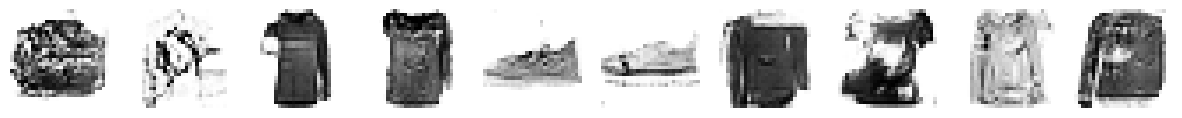

In [6]:
plot_images(10, dcgenerator, dc_latent_dim)

A problem you often encounter when training DCGANs is that you get locally convincing features but overall inconsistensies - here, you can see a "classic": Shirts with one long and one short sleeve.